In [56]:
import pickle
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

import fasttext
import fasttext.util
from keras.models import Model
from keras.layers import Dropout,Input
# from tensorflow_addons.layers import CRF
from keras.layers import Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.callbacks import Callback
from keras.preprocessing.text import *
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.layers import GRU, SimpleRNN, LSTM, Bidirectional
from keras.layers import TimeDistributed
from keras.metrics import F1Score, Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score,classification_report
from tensorflow.keras.optimizers import AdamW
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import AdamW, Adam, RMSprop, SGD
import pandas as pd


In [57]:
PATH = "D:/ghd/NLP-Assignments/Assignment2/"
OUTPATH = "D:/ghd/NLP-Assignments/Assignment2/"
# PATH = "D:/nlp/"
# OUTPATH = ""
# Any results you write to the current directory are saved as output.

In [58]:
Embedding_name="word2vec"
Dataset="NER"
task=''
if Dataset=="NER":
    task="t2"
elif Dataset=="ATE":
    task="t1"

In [59]:
def checking(a):
    print("Hello World",a)

def new_checking(a):
    print("Hello World",a)

def create_train_test_val(file):
    lst_out_text=[]
    lst_out_labels=[]
    for i in file.values():
        sentence = i['text']
        sentence = sentence.lower()
        labels = i['labels']
        lst_out_text.append(sentence)
        lst_out_labels.append(labels)
    return lst_out_text,lst_out_labels    

def TokenCreator(sentences,val,tokenizer=None):
    
    temp_wordlist = None
    tokenizer2=None
    if(tokenizer == None):
        if val==1:
            tokenizer2 = Tokenizer(oov_token="#UK",filters='')
        else:
            tokenizer2=Tokenizer()
        tokenizer2.fit_on_texts(sentences)
        
        temp_wordlist = tokenizer2.texts_to_sequences(sentences)
        return (temp_wordlist,tokenizer2)
    
    else:
        temp_wordlist = tokenizer.texts_to_sequences(sentences)
        return temp_wordlist
    
def find_vocab(dataset):
    lst=[]
    lst.append("#UK")
    for i in dataset:
        for j in i:
            lst.append(j)
    st = set(lst)
    return st

'''
--------------------------------------GRAPHS--------------------------------------
'''

def draw_loss_graph(model,model_name,f1_scores_train,f1_scores_val):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = [i+1 for i in range(len(train_loss))]
    train_y = train_loss
    val_y = val_loss
    
    fig, axes = plt.subplots(1,2,figsize = (16,5))
    # plt.subplots(axes = (2,1))
    axes[0].plot(x,train_y, color = 'blue')  
    
    axes[0].plot(x,val_y, color = 'red') 
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(x,f1_scores_train, color = 'blue')
    axes[1].plot(x,f1_scores_val, color = 'red')
    axes[1].set_title('F1 Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')

    axes[0].legend(['Train','Val'])
    axes[1].legend(['Train','Val'])
    
    plt.suptitle(model_name)

    
    plt.savefig(f'{OUTPATH}Graphs/{model_name}.png')
    plt.show()
    

In [60]:
'''
--------------------------------------MODELS--------------------------------------
'''

def save_model(model,model_name, embedding, dataset):
    with open(f'{PATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name, embedding, dataset):
    with open(f'{OUTPATH}Final_Models/{dataset}/{task}_{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model


In [61]:
'''
--------------------------------------CALLBACKS--------------------------------------
'''

class F1ScoreCallback(Callback):

    def __init__(self, val_data, data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.data=data
        self.val_f1_scores = [] 
        self.train_f1_scores = []

    

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.val_data
        x_data, y_data = self.data
        y_pred_val = self.model.predict(x_val)
        y_pred_train = self.model.predict(x_data)

        def scikitf1(pred,real):

            true_labels_flat = [label for sublist in real for label in sublist]
            predicted_labels_flat = [label for sublist in pred for label in sublist]
            # Compute F1 score
            f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
            return f1
        def get_pred(Y_padded_output):
                # print(Y_padded_output.shape)
                final_output=[]
                for i in range(Y_padded_output.shape[0]):
                    output=[]
                    for j in range(Y_padded_output.shape[1]):
                        max_value=-1
                        maxIndex=-1
                        for k in range(Y_padded_output.shape[2]):
                            if Y_padded_output[i][j][k]>max_value:
                                maxIndex=k
                                max_value=max(max_value,Y_padded_output[i][j][k])
                        output.append(maxIndex)
                    final_output.append(output)
                return final_output

        def get_real(Y_padded_test):
            # print(Y_padded_test.shape)
            final_Y=[]
            for i in range(Y_padded_test.shape[0]):
                output=[]
                for j in range(Y_padded_test.shape[1]):
                    max_value=-1
                    maxIndex=-1
                    for k in range(Y_padded_test.shape[2]):
                        if Y_padded_test[i][j][k]>max_value:
                            maxIndex=k
                            max_value=max(max_value,Y_padded_test[i][j][k])
                    output.append(maxIndex)
                final_Y.append(output)
            return final_Y
        
        # print("here")
        pred_train=get_pred(y_pred_train)
        # print(pred_train)
        real_train=get_real(y_data)
        # print(real_train)

        pred_val=get_pred(y_pred_val)
        real_val=get_real(y_val)

        f1_train = scikitf1(pred_train,real_train)
        f1_val = scikitf1(pred_val,real_val)

        self.val_f1_scores.append(f1_val)
        self.train_f1_scores.append(f1_train)
        print(f'Val F1 Score: {f1_val} - Train F1 Score: {f1_train}')



#---------Prediction Functions----------------------------------------------
def get_pred(Y_padded_output):
    final_output=[]
    for i in range(Y_padded_output.shape[0]):
        output=[]
        for j in range(Y_padded_output.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_output.shape[2]):
                if Y_padded_output[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_output[i][j][k])
            output.append(maxIndex)
        final_output.append(output)
    return final_output

def get_real(Y_padded_test):
    final_Y=[]
    for i in range(Y_padded_test.shape[0]):
        output=[]
        for j in range(Y_padded_test.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_test.shape[2]):
                if Y_padded_test[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_test[i][j][k])
            output.append(maxIndex)
        final_Y.append(output)
    return final_Y

def my_f1(y_true, y_pred):
    
    # predictions = get_pred(y_pred)
    # real = get_real(y_true)

    predictions = y_pred
    real = y_true

    size=len(predictions)

    unique_labels= set()

    for labels in real:
        unique_labels.update(labels)

    for labels in predictions:
        unique_labels.update(labels)

    labels_f1=[]

    for labels in unique_labels:
        tp=0
        fp=0
        fn=0

        for i in range(size):
                    
            tp+=sum((p==labels and r==labels) for p,r in zip(predictions[i],real[i]))
            fp+=sum((p==labels and r!=labels) for p,r in zip(predictions[i],real[i]))
            fn+=sum((p!=labels and r==labels) for p,r in zip(predictions[i],real[i]))

        
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall = tp/(tp+fn) if tp+fn>0 else 0

        f1=2*((precision*recall)/(precision+recall)) if precision+recall>0 else 0

        labels_f1.append(f1)
        print(f1,unique_labels)
    macro_f1 = sum(labels_f1)/len(unique_labels)
    return macro_f1

def scikitf1(pred,real):

    true_labels_flat = [label for sublist in real for label in sublist]
    predicted_labels_flat = [label for sublist in pred for label in sublist]
    # Compute F1 score
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
    return f1

In [62]:
def report_alllabels(pred,real):
    tag_mapping={v:k for k,v in toke2.word_index.items()}
    tag_mapping[0]="PAD"
    labels=list(tag_mapping.values())
    def convert_sentences_to_values(sentences, word_values):
        result = []
        for sentence in sentences:
            values = []
            for word in sentence:
                values.append(word_values[word])
            result.append(values)
        return result

    y_pred_labels = convert_sentences_to_values(pred,tag_mapping)
    y_true_labels=convert_sentences_to_values(real,tag_mapping)

    print(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels))
    
    df=pd.DataFrame(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)).T
    # all_label_report=classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)
    x = df.index
    x = x[0:-3]
    y = [df.loc[i,'f1-score'] for i in x]
    plt.figure(figsize=(10,8))
    plt.bar(x,y)
    plt.xticks(rotation=90)
    plt.xlabel('Class Labels')
    plt.ylabel('F1-Score')
    plt.title('Classwise F1-Score')

def report_13labels(pred,real):
    tag_mapping={v:k for k,v in toke2.word_index.items()}
    tag_mapping[0]="PAD"
    labels=list(tag_mapping.values())
    def convert_sentences_to_values(sentences, word_values):
        result = []
        for sentence in sentences:
            values = []
            for word in sentence:
                values.append(word_values[word])
            result.append(values)
        return result

    y_pred_labels = convert_sentences_to_values(pred,tag_mapping)
    y_true_labels=convert_sentences_to_values(real,tag_mapping)

    for i in range(len(y_pred_labels)):
        for j in range(len(y_pred_labels[i])):
            # print(y_true_labels[i][j],y_pred_labels[i][j])
            y_true_labels[i][j]=y_true_labels[i][j].replace('i_','b_')
            y_pred_labels[i][j]=y_pred_labels[i][j].replace('i_','b_')

            y_true_labels[i][j]=y_true_labels[i][j].replace('b_','')
            y_pred_labels[i][j]=y_pred_labels[i][j].replace('b_','')
            
    labels2=[]
    for i in labels:
        if 'i_' not in i:
            labels2.append(i)

    for j in range(len(labels2)):
        labels2[j]=labels2[j].replace('b_','')

    report = classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels2)
    print(report)
    df2=pd.DataFrame(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels2,output_dict=True)).T
# all_label_report=classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)
    x = df2.index
    x = x[1:-4]
    y = [df2.loc[i,'f1-score'] for i in x]
    plt.figure(figsize=(10,8))
    plt.bar(x,y)
    plt.xticks(rotation=90)
    plt.xlabel('Class Labels')
    plt.ylabel('F1-Score')
    plt.title('Classwise F1-Score')

In [63]:
seed_value = 18
np.random.seed(seed_value)


In [64]:
if Embedding_name=="word2vec":
    emb = KeyedVectors.load_word2vec_format(f'{PATH}WordEmbeddings/Word2Vec.bin',binary=True)
if Embedding_name=="glove":
    with open(f'{PATH}WordEmbeddings/glove.840B.300d.pkl', 'rb') as fp:
        emb = pickle.load(fp)
if Embedding_name=="fasttext":
    emb = fasttext.load_model(f'{PATH}WordEmbeddings/cc.en.300.bin')

# Preproc

In [65]:
train = None
test = None
val = None
with open(f"{PATH}Data/processed/{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"{PATH}Data/processed/{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"{PATH}Data/processed/{Dataset}_val.json") as f3:
    val = json.load(f3)



In [66]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

In [67]:
X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 

max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

print(max_len)

X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")  

Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 


70


In [68]:
for word, index in mapping.items():
    if word in emb:
        weights[index:] = emb[word]

In [69]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2
Y_shape= Y_padded_train.shape[2]

# TRAINING

## RNN

In [70]:
model_name="RNN"

Loading the rnn Model

In [71]:
def rnn(vocab_size,max_len,weights,Y_shape):
    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
    rnn_model.add(SimpleRNN(32, return_sequences=True))
    rnn_model.add(TimeDistributed(Dense(Y_shape, activation='softmax')))
    rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])
    return rnn_model

In [72]:
rnn_loaded_model = rnn(vocab_size,max_len,weights,Y_shape)
params1=load_model(model_name,Embedding_name,Dataset)
rnn_loaded_model.set_weights(params1)

In [73]:
accuracy = rnn_loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 1s 7ms/step - loss: 0.3271 - acc: 0.9281 - precision_7: 0.9495 - recall_7: 0.9121
0.9280596375465393


In [74]:
Y_pred = rnn_loaded_model.predict(X_test)
rnn_real = get_real(Y_test)
rnn_pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in rnn_real for label in sublist]
predicted_labels_flat = [label for sublist in rnn_pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 0s 4ms/step
Test F1 Score: 0.21580725181495963


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

             o       0.98      1.00      0.99     32840
   i_precedent       0.00      0.00      0.00       121
   i_provision       0.87      0.45      0.59       178
 i_case_number       0.71      0.11      0.19       221
     i_statute       0.29      0.01      0.02       183
b_other_person       0.00      0.00      0.00         8
         i_org       0.00      0.00      0.00       159
       i_court       0.33      0.01      0.01       275
   b_provision       0.00      0.00      0.00         9
i_other_person       0.00      0.00      0.00       177
        b_date       0.81      0.70      0.75       258
     b_statute       0.00      0.00      0.00         5
         b_org       0.71      0.05      0.10       220
         b_gpe       0.00      0.00      0.00        58
        i_date       0.78      0.05      0.10       344
   b_precedent       0.71      0.43      0.53       326
       b_court       0.00      0.00      0.00  

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           o       0.98      1.00      0.99     32840
other_person       0.78      0.04      0.07       465
   provision       0.81      0.46      0.59       504
        date       0.74      0.08      0.14       323
     statute       0.29      0.01      0.02       230
         org       0.00      0.00      0.00        15
         gpe       0.89      0.97      0.93     27699
   precedent       0.00      0.00      0.00       469
       court       0.43      0.10      0.16       473
 case_number       0.00      0.00      0.00        20
     witness       0.83      0.56      0.66      1970
       judge       0.88      0.64      0.74       696
  petitioner       0.00      0.00      0.00        14
  respondent       0.75      0.12      0.21       600
         PAD       0.00      0.00      0.00       112

    accuracy                           0.93     66430
   macro avg       0.49      0.27      0.30     66430
weighted avg       0.91   

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

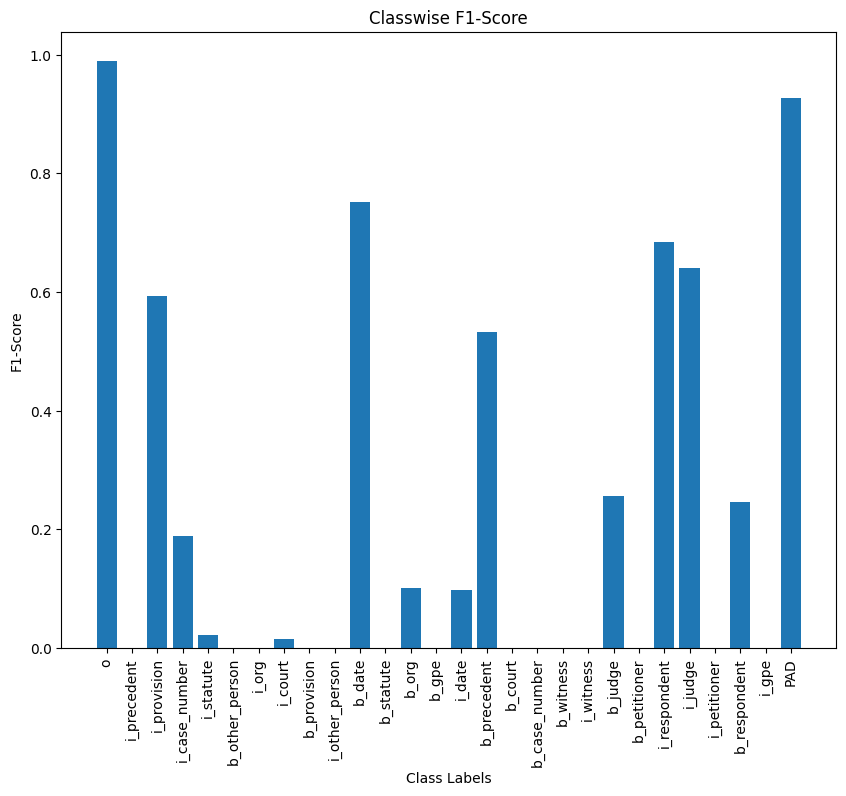

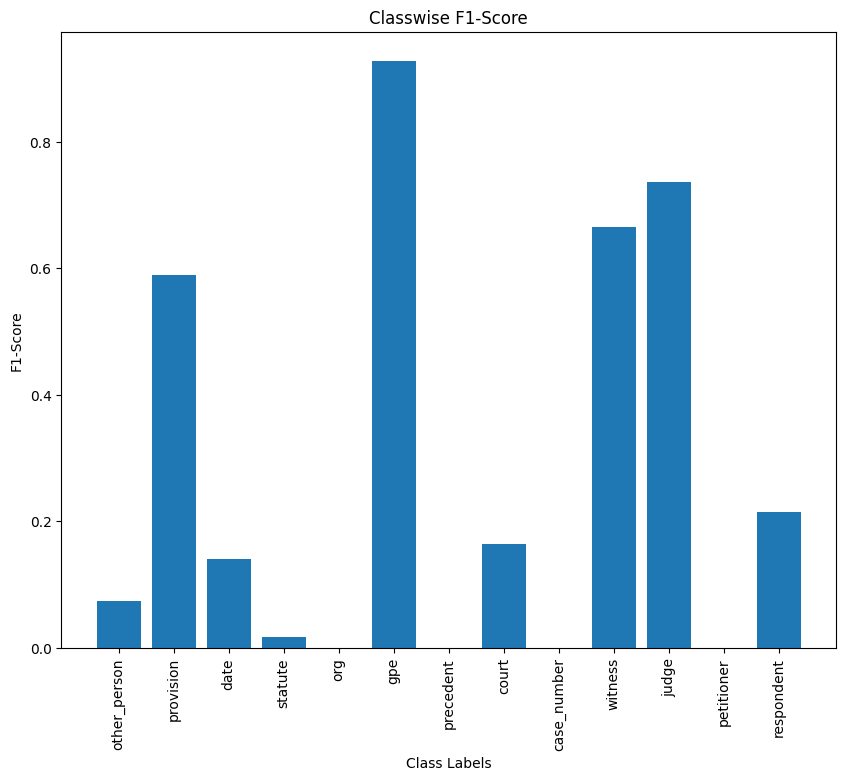

In [75]:
pred=rnn_pred
real=rnn_real
report_alllabels(pred,real)
report_13labels(pred,real)

## LSTM

In [76]:
model_name="LSTM"

In [77]:
def lstm(vocab_size,max_len,weights,Y_shape):
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
    lstm_model.add(LSTM(128, return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))# Lstm
    lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])    
    return lstm_model

In [78]:
params2 = load_model(model_name,Embedding_name,Dataset)
lstm_loaded_model=lstm(vocab_size,max_len,weights,Y_shape)
lstm_loaded_model.set_weights(params2)

In [79]:
accuracy = lstm_loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 2s 16ms/step - loss: 0.2474 - acc: 0.9421 - precision_8: 0.9559 - recall_8: 0.9313
0.942059338092804


In [80]:
Y_pred = lstm_loaded_model.predict(X_test)
lstm_real = get_real(Y_test)
lstm_pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in lstm_real for label in sublist]
predicted_labels_flat = [label for sublist in lstm_pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 1s 17ms/step
Test F1 Score: 0.36683018906692705


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

             o       0.98      1.00      0.99     32840
   i_precedent       0.63      0.10      0.17       121
   i_provision       0.86      0.60      0.71       178
 i_case_number       0.80      0.57      0.66       221
     i_statute       0.38      0.10      0.16       183
b_other_person       0.00      0.00      0.00         8
         i_org       0.75      0.04      0.07       159
       i_court       0.47      0.05      0.09       275
   b_provision       1.00      0.11      0.20         9
i_other_person       0.59      0.27      0.37       177
        b_date       0.82      0.74      0.78       258
     b_statute       0.00      0.00      0.00         5
         b_org       0.77      0.50      0.61       220
         b_gpe       0.00      0.00      0.00        58
        i_date       0.59      0.40      0.48       344
   b_precedent       0.72      0.58      0.64       326
       b_court       0.80      0.66      0.72  

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           o       0.98      1.00      0.99     32840
other_person       0.63      0.34      0.44       465
   provision       0.80      0.61      0.69       504
        date       0.82      0.61      0.70       323
     statute       0.42      0.09      0.14       230
         org       0.00      0.00      0.00        15
         gpe       0.92      0.97      0.94     27699
   precedent       0.46      0.13      0.20       469
       court       0.52      0.16      0.24       473
 case_number       1.00      0.05      0.10        20
     witness       0.85      0.72      0.78      1970
       judge       0.90      0.73      0.80       696
  petitioner       0.00      0.00      0.00        14
  respondent       0.75      0.53      0.62       600
         PAD       0.00      0.00      0.00       112

    accuracy                           0.94     66430
   macro avg       0.60      0.40      0.44     66430
weighted avg       0.93   

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

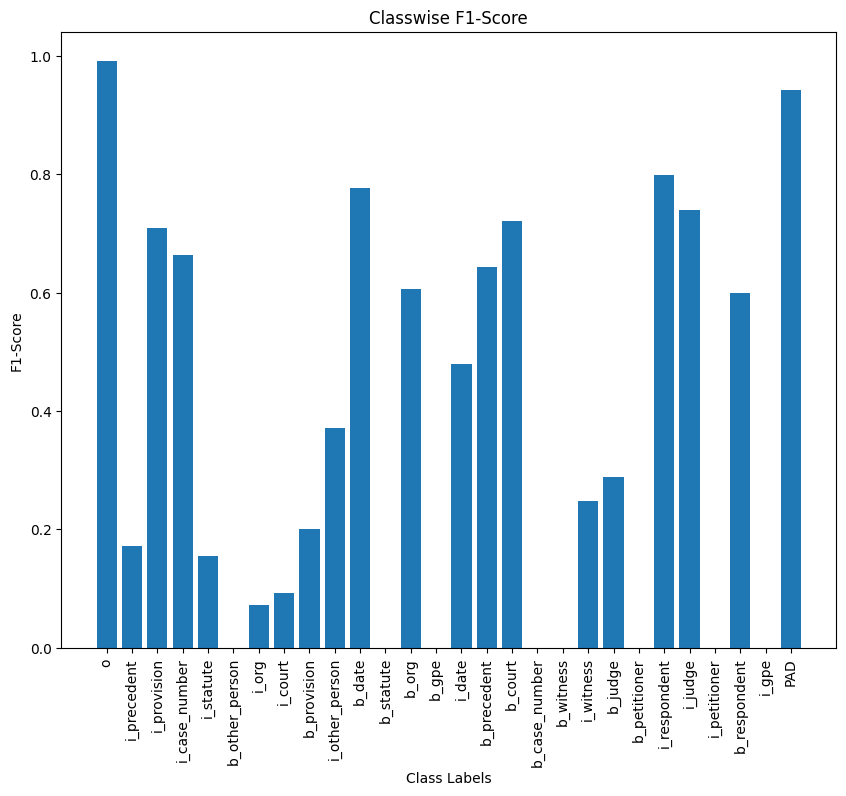

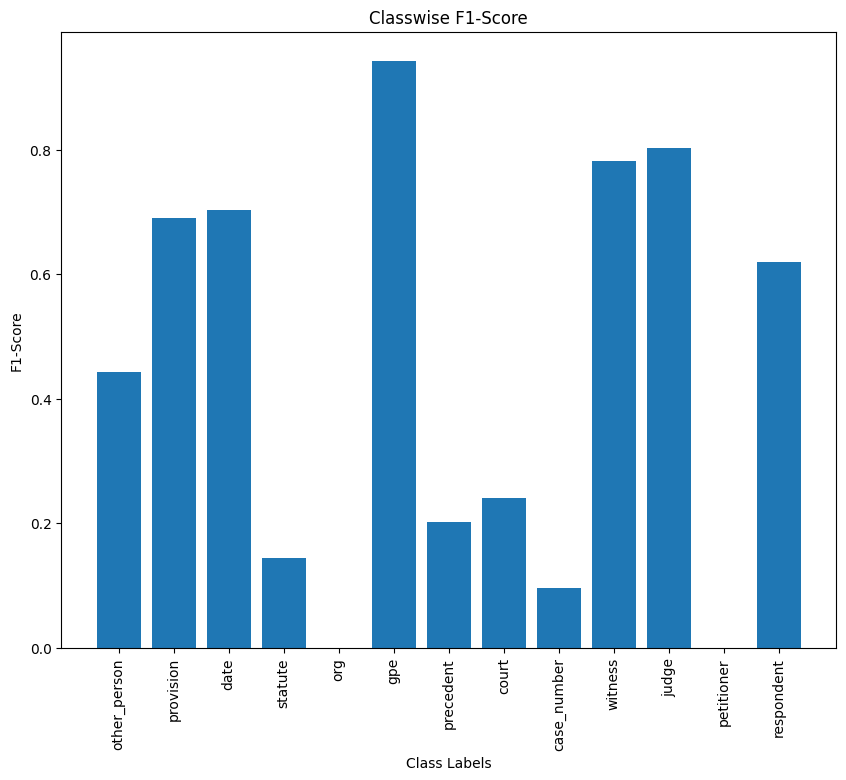

In [81]:
pred=lstm_pred
real=lstm_real
report_alllabels(pred,real)
report_13labels(pred,real)

## GRU

In [82]:
model_name="GRU"

In [83]:
def gru(vocab_size,max_len,weights,Y_train_shape):
    gru_model = Sequential()
    gru_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
    gru_model.add(GRU(64, return_sequences=True))
    gru_model.add(TimeDistributed(Dense(Y_train_shape, activation='softmax')))
    gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])
    return gru_model

In [84]:
params3 = load_model(model_name,Embedding_name,Dataset)
gru_loaded_model=gru(vocab_size,max_len,weights,Y_shape)
gru_loaded_model.set_weights(params3)

In [85]:
accuracy = gru_loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

30/30 [==============================] - 1s 11ms/step - loss: 0.2526 - acc: 0.9418 - precision_9: 0.9540 - recall_9: 0.9317
0.94183349609375


In [86]:
Y_pred = gru_loaded_model.predict(X_test)
gru_real = get_real(Y_test)
gru_pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in gru_real for label in sublist]
predicted_labels_flat = [label for sublist in gru_pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

30/30 [==============================] - 1s 8ms/step
Test F1 Score: 0.380250220419787


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

             o       0.98      1.00      0.99     32840
   i_precedent       0.72      0.11      0.19       121
   i_provision       0.86      0.58      0.69       178
 i_case_number       0.79      0.48      0.60       221
     i_statute       0.43      0.13      0.19       183
b_other_person       0.00      0.00      0.00         8
         i_org       0.62      0.05      0.09       159
       i_court       0.31      0.05      0.09       275
   b_provision       1.00      0.33      0.50         9
i_other_person       0.69      0.19      0.30       177
        b_date       0.82      0.76      0.79       258
     b_statute       0.00      0.00      0.00         5
         b_org       0.77      0.43      0.55       220
         b_gpe       0.00      0.00      0.00        58
        i_date       0.65      0.27      0.38       344
   b_precedent       0.77      0.54      0.63       326
       b_court       0.81      0.65      0.72  

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           o       0.98      1.00      0.99     32840
other_person       0.70      0.24      0.36       465
   provision       0.84      0.58      0.68       504
        date       0.83      0.55      0.66       323
     statute       0.43      0.10      0.16       230
         org       0.00      0.00      0.00        15
         gpe       0.91      0.97      0.94     27699
   precedent       0.58      0.17      0.26       469
       court       0.54      0.16      0.25       473
 case_number       1.00      0.20      0.33        20
     witness       0.88      0.65      0.75      1970
       judge       0.88      0.78      0.82       696
  petitioner       0.00      0.00      0.00        14
  respondent       0.77      0.51      0.61       600
         PAD       0.25      0.01      0.02       112

    accuracy                           0.94     66430
   macro avg       0.64      0.39      0.46     66430
weighted avg       0.93   

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

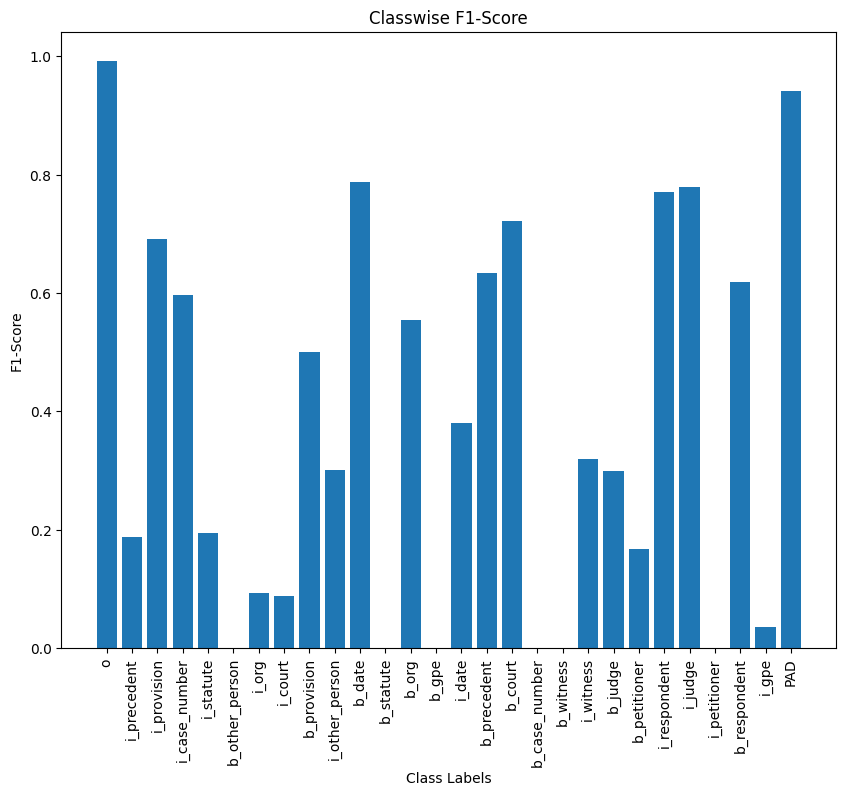

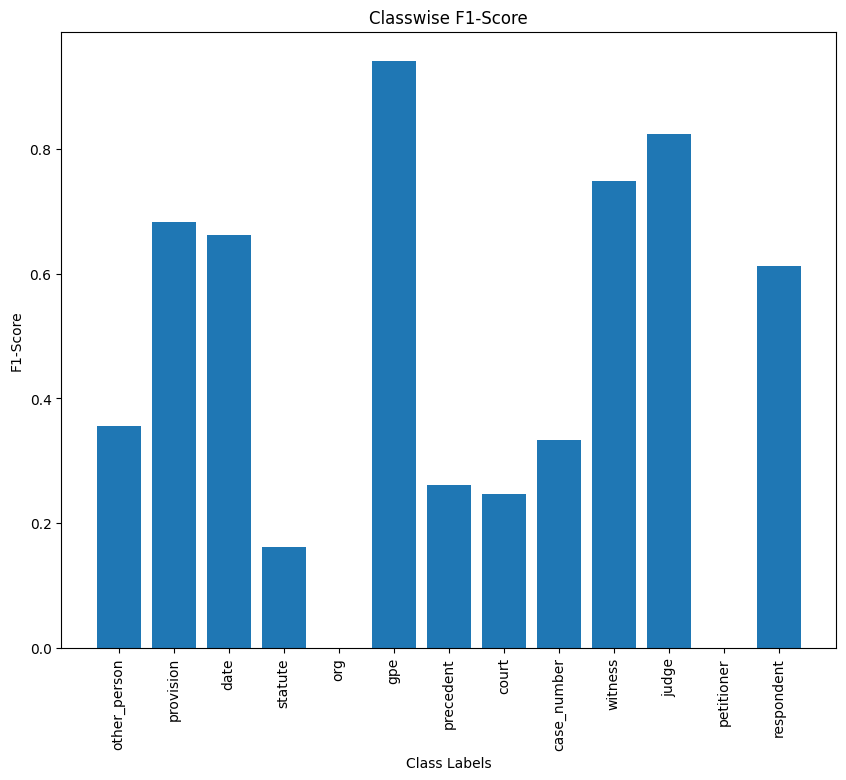

In [87]:
pred=gru_pred
real=gru_real
report_alllabels(pred,real)
report_13labels(pred,real)